In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import GaussianNoise

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.applications.imagenet_utils import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
def load_dataset_all(data_dir,  n, im_size):
    """ Function used to load the test set
    # Arguments
        data_dir: directory containing the data to load
        n: number of data samples
        im_size: desired image size (aspect ration will be 1:1)
    # Expected data format
        images should be numbered from 1 to n
    # Returns
        x: numpy array with the loaded images
    """
    x = []
    for i in range (0, n):
            img_train = load_img(data_dir+str(i)+'.png',target_size=(im_size, im_size), color_mode = "grayscale")
            img_array_train = img_to_array(img_train)
            x.append(img_array_train)
       
    x = np.array(x)
    
    return x

In [5]:
from os.path import dirname, abspath
parent_dir = dirname(dirname(abspath(os.getcwd())))

#Parent dir is two levels above the current directory, containing two folders: Models and Datasets. 
    #Datasets should be inside the Datasets dir, in folders named datasetn, where n is the number that
    #identifies the dataset in use
    
dataset_id_str = raw_input("Enter the dataset number: ")

#desired image width (height will be the same)
image_size_str = raw_input("Enter the tile size: ")
im_target_size = int(image_size_str)
image_size = im_target_size

#inside the dataset folder are two folders: train and test. Inside the train folder are two folders with images
    #of ships (cropped_ships) and without ships (cropped_regular). We put those images inside another folder
    #called /all because keras data generators need the data inside the directory to be separated into folders, 
    #one for each class, even if there is only one class, which is the case.
DIR_train = parent_dir+'/Datasets/dataset'+dataset_id_str+'/train/cropped_regular/'
DIR_test = parent_dir+'/Datasets/dataset'+dataset_id_str+'/test/all/'

#record runs by the number
test_number_str = raw_input("Enter the run number: ")
test_number = int(test_number_str)

#create dir to save output data
results_dir ='Outputs/dataset'+dataset_id_str+'/'+str(test_number)
test_results_id = '/weights.h5'

#if yes, model will be trained and any existing results for the given run number will be replaced
#if no, the model will be loaded with the previously obtained weights and the results for this run will be 
    #shown
to_train = raw_input("Do you want to train the model?(yes/no)")
    
if not os.path.exists(results_dir):
        os.makedirs(results_dir)


Enter the dataset number: 1
Enter the tile size: 56
Enter the run number: 501
Do you want to train the model?(yes/no)yes


In [6]:
#load test set
DIR_test = parent_dir+'/Datasets/dataset'+dataset_id_str+'/test/all/'
n_test = len([name for name in os.listdir(DIR_test) if os.path.isfile(os.path.join(DIR_test, name))])
x_test = load_dataset_all(data_dir=DIR_test, n = n_test, im_size = im_target_size)
x_test = x_test/255.

In [7]:
#in this case the test dir contains 2000 test images, but we only want the last 1500 since they contain 500
 #images with ships and 1000 without ships
x_test = x_test[500:]
n_test = 1500
print(x_test.shape)

(1500, 56, 56, 1)


In [8]:
#model parameters
batch_size = 128

#kernel sizes for each of the conv2d and conv2dtranspose layers
kernel_size_1 = 3
kernel_size_2 = 3
kernel_size_3 = 3

beta = 0.3

#reconstruction error
#choose between mse ('mse') and binary crossentropy (any text other than 'mse' will choose binary crossentropy)
error_metric = 'mse'

optimizer = 'adam'

learning_rate = 0.0003

#initial number of filters (will duplicate every conv layer)
filters = 16

latent_dim = 256

epochs = 300

#replace with 'yes' if a layer with noise should be added after the input layer
add_noise = 'no'
noise_stdd = 0



In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
DIR_train = parent_dir+'/Datasets/dataset'+dataset_id_str+'/train/cropped_regular/'
train_generator = train_datagen.flow_from_directory(
        DIR_train,
        target_size=(im_target_size, im_target_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='input',
        subset='training',
        seed = 10, shuffle = False)

validation_generator = train_datagen.flow_from_directory(
    DIR_train, # same directory as training data
    target_size=(im_target_size, im_target_size),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='input',
    subset='validation',
    seed = 10, shuffle = False) # set as validation data

Found 32092 images belonging to 1 classes.
Found 10697 images belonging to 1 classes.


In [10]:
#encoder model
import keras as keras
from keras.layers import MaxPooling2D
input_shape = (im_target_size, im_target_size, 1)
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
if add_noise == 'yes':
    x = GaussianNoise(noise_stdd)(x)
x = Conv2D(filters=filters, kernel_size=kernel_size_1, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*2, kernel_size=kernel_size_2, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*4, kernel_size=kernel_size_3, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)


# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [12]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file=results_dir+'/encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 28, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [13]:
#decoder model
from keras.layers import UpSampling2D

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)


x = Conv2DTranspose(filters=filters*4, kernel_size=kernel_size_3, activation='relu', strides=1, padding='same')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(filters=filters*2, kernel_size=kernel_size_2, activation='relu', strides=1, padding='same')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(filters=filters*1, kernel_size=kernel_size_2, activation='relu', strides=1, padding='same')(x)
x = UpSampling2D()(x)





outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size_1,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


In [14]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file=results_dir+'/decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              805952    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 32)        0         
__________

In [15]:
#save details of the run in the results (outputs) folder
if to_train == 'yes':
    print('saving experiment details')
    filename_str = results_dir+"/experiment{}_details.txt".format(test_number)

    if os.path.isfile(filename_str):
        os.remove(filename_str)

    f= open(filename_str,"w+")

    f.write("Epochs %d\r\n" % (epochs))
    f.write("Latent dim %d\r\n" % (latent_dim))
    f.write("Batch size %d\r\n" % (batch_size))
    f.write("Kernel size 1 %d\r\n" % (kernel_size_1))
    f.write("Kernel size 2 %d\r\n" % (kernel_size_2))
    f.write("Kernel size 3 %d\r\n" % (kernel_size_3))
    f.write("Learning Rate %f\r\n" % (learning_rate))
    f.write("Loss function %s\r\n" % (error_metric))
    f.write("Optimizer %s\r\n" % (optimizer))
    f.write("Beta %f\r\n" % (beta))
    f.write("Noise added: %s\r\n" % (add_noise))
    f.write("noise_stdd %f\r\n" % (noise_stdd))





    f.close()

saving experiment details


In [16]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

#callbacks to save history and stop training if no progress has been registered
callbacks_list = [keras.callbacks.History(), 
                  keras.callbacks.EarlyStopping(monitor='loss', 
                                                          min_delta=0.05, 
                                                          patience=10, 
                                                          verbose=0, 
                                                          mode='min', 
                                                          baseline=None, 
                                                          restore_best_weights=True)]


if __name__ == '__main__':
    
    
    models = (encoder, decoder)
    data = (x_test, None)

    def vae_custom_loss(inputs, outputs):
        if error_metric == 'mse':
            reconstruction_loss =  mse(K.flatten(inputs), K.flatten(outputs))
            print('Using mse loss')
        else:
            reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                      K.flatten(outputs))

        reconstruction_loss *= image_size * image_size
        


        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -beta*0.5
        return K.mean(reconstruction_loss + kl_loss)
    
    vae.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss=vae_custom_loss)
    vae.summary()
    plot_model(vae, to_file=results_dir+'/vae.png', show_shapes=True)
    if to_train == 'no':
        vae.load_weights(results_dir+test_results_id)
    elif to_train == 'yes':
        history = vae.fit_generator(train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps = validation_generator.samples // batch_size,
                callbacks=callbacks_list)
                
        vae.save_weights(results_dir+test_results_id)

Using mse loss
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 56, 56, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 256), (None, 256) 1629440   
_________________________________________________________________
decoder (Model)              (None, 56, 56, 1)         866113    
Total params: 2,495,553
Trainable params: 2,495,553
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
250/250 [==============================] - 20s 81ms/step - loss: 62.9839 - val_loss: 34.6008
Epoch 2/300
250/250 [==============================] - 15s 59ms/step - loss: 34.7695 - val_loss: 33.0079
Epoch 3/300
250/250 [==============================] - 15s 59ms/step - loss: 33.3663 - val_loss: 31.7072
Epoch 4/300
250/25

Epoch 69/300
250/250 [==============================] - 14s 57ms/step - loss: 25.4071 - val_loss: 24.9398
Epoch 70/300
250/250 [==============================] - 14s 57ms/step - loss: 25.3831 - val_loss: 24.9547
Epoch 71/300
250/250 [==============================] - 14s 57ms/step - loss: 25.3298 - val_loss: 24.8843
Epoch 72/300
250/250 [==============================] - 14s 57ms/step - loss: 25.2838 - val_loss: 25.0046
Epoch 73/300
250/250 [==============================] - 14s 57ms/step - loss: 25.3032 - val_loss: 25.0405
Epoch 74/300
250/250 [==============================] - 14s 57ms/step - loss: 25.3221 - val_loss: 24.9450
Epoch 75/300
250/250 [==============================] - 14s 57ms/step - loss: 25.2625 - val_loss: 24.9610
Epoch 76/300
250/250 [==============================] - 14s 57ms/step - loss: 25.2324 - val_loss: 24.9377
Epoch 77/300
250/250 [==============================] - 14s 57ms/step - loss: 25.2118 - val_loss: 24.7994
Epoch 78/300
250/250 [========================

Epoch 146/300
250/250 [==============================] - 14s 57ms/step - loss: 24.3366 - val_loss: 25.0119
Epoch 147/300
250/250 [==============================] - 14s 58ms/step - loss: 24.2941 - val_loss: 25.0715
Epoch 148/300
250/250 [==============================] - 14s 57ms/step - loss: 24.3216 - val_loss: 25.1880
Epoch 149/300
250/250 [==============================] - 14s 57ms/step - loss: 24.2874 - val_loss: 25.1230
Epoch 150/300
250/250 [==============================] - 14s 57ms/step - loss: 24.3275 - val_loss: 25.0731
Epoch 151/300
250/250 [==============================] - 14s 57ms/step - loss: 24.3003 - val_loss: 25.1345
Epoch 152/300
250/250 [==============================] - 14s 57ms/step - loss: 24.2793 - val_loss: 25.1469
Epoch 153/300
250/250 [==============================] - 14s 57ms/step - loss: 24.3152 - val_loss: 25.1378
Epoch 154/300
250/250 [==============================] - 14s 57ms/step - loss: 24.2886 - val_loss: 25.1812
Epoch 155/300
250/250 [==============

/home/addicted/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:2096: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


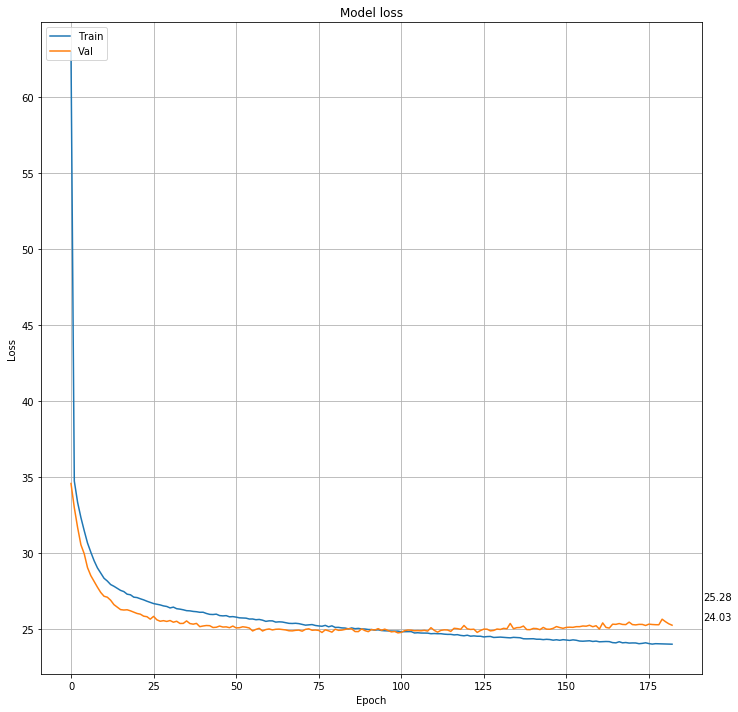

In [17]:
# Plot training & validation loss values
%matplotlib inline
if to_train == 'yes':
    np.save(results_dir+'/train_loss', history.history['loss'])
    np.save(results_dir+'/val_loss', history.history['val_loss'])
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
else:
    train_losses = np.load(results_dir+'/train_loss.npy')
    val_losses = np.load(results_dir+'/val_loss.npy')
    
plt.figure(figsize=(10,10))
plt.plot(train_losses[:])
plt.annotate('%0.2f' % train_losses[-1], xy=(1, train_losses[-1]),  
                     xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.plot(val_losses[:])
plt.annotate('%0.2f' % val_losses[-1], xy=(1, val_losses[-1]),  
                     xycoords=('axes fraction', 'data'), textcoords='offset points')
axes = plt.gca()


plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.grid()
plt.tight_layout()

plt.savefig(results_dir+'/loss.png')


In [18]:
# indexes of the test set with anomalies
anomalies_list = range(0,500)
    
y_test = []

#build labels array
for j in range(0, n_test):
    if j not in anomalies_list:
        y_test.append(0)
    else:
        y_test.append(1)

n_anomaly = len(anomalies_list)

encoder, decoder = models

#generate means and log variances
z_mean,z_var,_ = encoder.predict(x_test, batch_size=batch_size)

anomaly_detected = []
anomalies = []

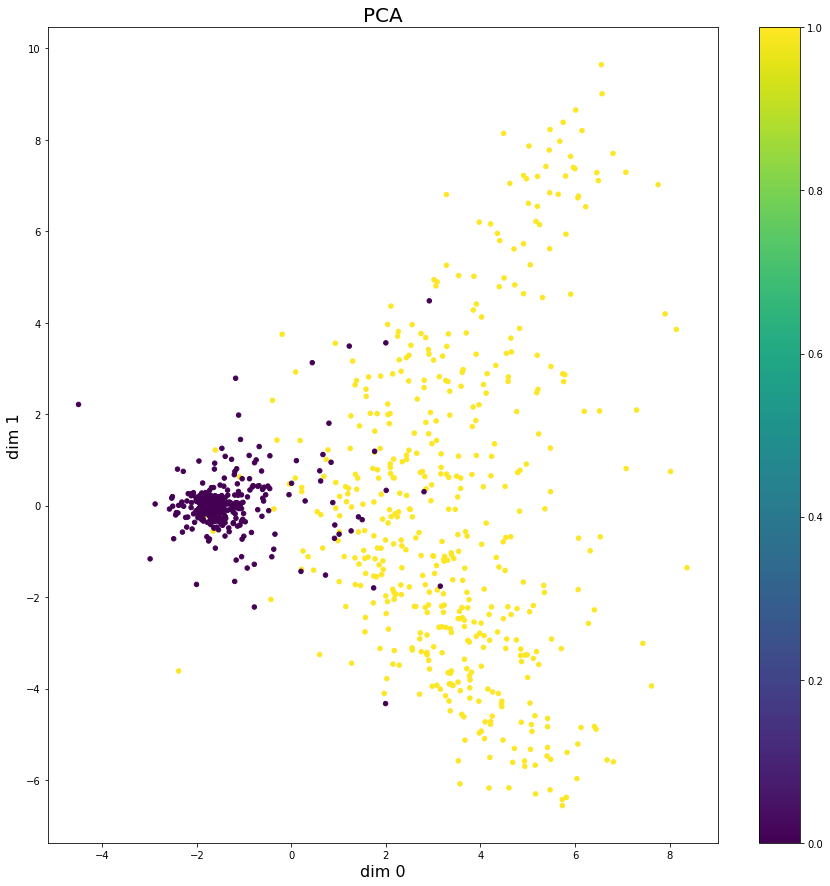

In [19]:
#plot pca for visualization purposes

from sklearn.decomposition import PCA

#get the two principal components
pca = PCA(n_components=2)

pca.fit(z_mean)

Z_pca = pca.transform(z_mean)
Z_pca.shape

plt.figure(figsize=(15,15))
plt.scatter(Z_pca[:,0], Z_pca[:, 1], c=y_test, s=20)
plt.colorbar()
plt.ylabel("dim 1", fontsize=16)
plt.xlabel("dim 0", fontsize = 16)
plt.title("PCA", fontsize = 20)
plt.savefig(results_dir+'/PCA_2D.png')

In [20]:
# # k means determine k
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix


def compute_metrics(y_true, y_pred):
    
    """
    Computes the evaluation metrics and prints them on the screen
    
    Arguments and returned variables names should be self-explanatory
        
    """

    conf_mat = confusion_matrix(y_pred = y_pred, y_true = y_true)
    print(conf_mat)

    true_negatives = conf_mat[0, 0]
    true_positives = conf_mat[1,1]
    false_positives = conf_mat[0, 1]
    false_negatives = conf_mat[1,0]

    model_precision = true_positives/(true_positives+false_positives)
    print("Model precision is: "+str(model_precision))

    model_recall = true_positives/(true_positives+false_negatives)
    print("Model recall is: "+str(model_recall))

    f1_score = 2*(model_precision*model_recall)/(model_precision+model_recall)
    print("Model f1 score is: "+str(f1_score))

    model_acc = (true_positives+true_negatives)/(len(y_true))
    print("Model accuracy is: "+str(model_acc))
    
    return model_precision, model_recall, f1_score, model_acc

[[985  15]
 [ 36 464]]
Model precision is: 0.9686847599164927
Model recall is: 0.928
Model f1 score is: 0.947906026557712
Model accuracy is: 0.966


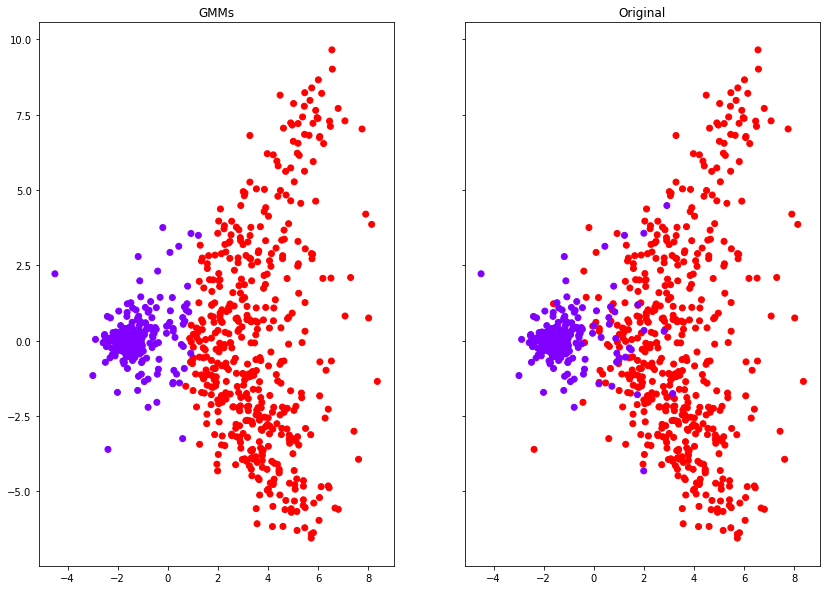

In [24]:
## Compute GMMs labels, compute the evaluation metrics and plot the results

gmm = GaussianMixture(n_components=2)
gmm.fit(z_mean)

gmm_labels = gmm.predict(z_mean)

gmm_metrics = compute_metrics(y_test, gmm_labels)




f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,10))
ax1.set_title('GMMs')
ax1.scatter(Z_pca[:,0],Z_pca[:,1],c=gmm_labels,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(Z_pca[:,0],Z_pca[:,1],c=y_test,cmap='rainbow')

[[984  16]
 [ 36 464]]
Model precision is: 0.9666666666666667
Model recall is: 0.928
Model f1 score is: 0.9469387755102041
Model accuracy is: 0.9653333333333334


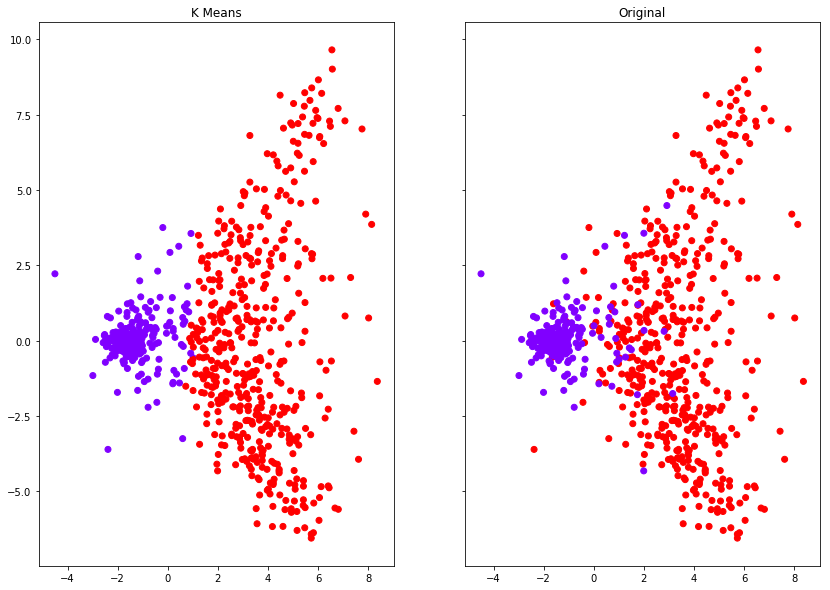

In [22]:
## Compute K-means labels, compute the evaluation metrics and plot the results


kmeans = KMeans(n_clusters=2)

kmeans.fit(z_mean)

kmeans_labels = kmeans.labels_

kmeans_metrics = compute_metrics(y_test, kmeans_labels)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,10))
ax1.set_title('K Means')
ax1.scatter(Z_pca[:,0],Z_pca[:,1],c=kmeans_labels,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(Z_pca[:,0],Z_pca[:,1],c=y_test,cmap='rainbow')

# CNN TRAINING

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
DIR_train = parent_dir+'/Datasets/dataset'+dataset_id_str+'/train/'
train_generator = train_datagen.flow_from_directory(
        DIR_train,
        target_size=(im_target_size, im_target_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        seed = 10, shuffle = True)

validation_generator = train_datagen.flow_from_directory(
    DIR_train, # same directory as training data
    target_size=(im_target_size, im_target_size),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed = 10, shuffle = True) # set as validation data

In [ ]:
input_shape2 = (im_target_size, im_target_size, 1)
inputs2 = Input(shape=input_shape2, name='cnn_input')

x = inputs2
x = Conv2D(filters=filters, kernel_size=kernel_size_1, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*2, kernel_size=kernel_size_2, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*4, kernel_size=kernel_size_3, activation='relu', strides=1, padding='same')(x)
x = MaxPooling2D()(x)



x = Flatten()(x)


x = Dense(16, activation='relu')(x)
o = Dense(1, activation='sigmoid')(x)



model2 = Model(input=inputs2, output=[o])
model2.summary()

from keras import optimizers
model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])





callbacks_list = [keras.callbacks.History(), 
                  keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                          min_delta=0.01, 
                                                          patience=10, 
                                                          verbose=0, 
                                                          mode='max', 
                                                          baseline=None, 
                                                          restore_best_weights=True)]


model2.fit_generator(train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                epochs=50,
                validation_data=validation_generator,
                validation_steps = validation_generator.samples // batch_size,
                callbacks=callbacks_list)



In [ ]:
y_predicted = model2.predict(x_test)
print(y_predicted<0.5)

In [ ]:
y_pred = []
for i in range(0, n_test):
    if y_predicted[i] < 0.5:
        y_pred.append(0)
    if y_predicted[i] >= 0.5:
        y_pred.append(1)
print(len(y_pred))

In [ ]:
compute_metrics(y_test, y_pred)